# Step 5.3: Machine Learning - Multiclass

Finally, we focus now on a multiclass SVM

In [1]:
# Import standard libraries
import os

# Import installed libraries
import numpy as np
import pandas as pd
import sklearn

from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [2]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

In [3]:
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [4]:
# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [5]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]

In [6]:
# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.MinMaxScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
import tensorflow.keras as keras

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


49
Epoch 1/10
67/67 - 1s - loss: 0.1490 - val_loss: 0.1215
Epoch 2/10
67/67 - 0s - loss: 0.0140 - val_loss: 0.0605
Epoch 3/10
67/67 - 0s - loss: 0.0106 - val_loss: 0.0320
Epoch 4/10
67/67 - 0s - loss: 0.0085 - val_loss: 0.0191
Epoch 5/10
67/67 - 0s - loss: 0.0082 - val_loss: 0.0138
Epoch 6/10
67/67 - 0s - loss: 0.0079 - val_loss: 0.0085
Epoch 7/10
67/67 - 0s - loss: 0.0074 - val_loss: 0.0072
Epoch 8/10
67/67 - 0s - loss: 0.0066 - val_loss: 0.0042
Epoch 9/10
67/67 - 0s - loss: 0.0060 - val_loss: 0.0031
Epoch 10/10
67/67 - 0s - loss: 0.0058 - val_loss: 0.0029


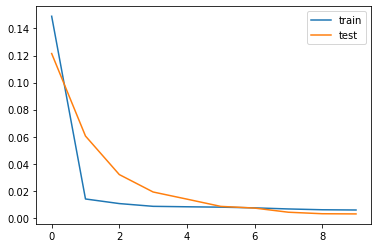

In [8]:
from matplotlib import pyplot
n_inputs = asteroids_X.shape[1]
print(n_inputs)

# define encoder
visible = keras.layers.Input(shape=(n_inputs,))
# encoder level 1
e = keras.layers.Dense(n_inputs*2)(visible)
e = keras.layers.BatchNormalization()(e)
e = keras.layers.LeakyReLU()(e)
# encoder level 2
e = keras.layers.Dense(n_inputs)(e)
e = keras.layers.BatchNormalization()(e)
e = keras.layers.LeakyReLU()(e)
# bottleneck
n_bottleneck = int(n_inputs / 5.0)
n_bottleneck = 2
bottleneck = keras.layers.Dense(n_bottleneck)(e)
# define decoder, level 1
d = keras.layers.Dense(n_inputs)(bottleneck)
d = keras.layers.BatchNormalization()(d)
d = keras.layers.LeakyReLU()(d)
# decoder level 2
d = keras.layers.Dense(n_inputs*2)(d)
d = keras.layers.BatchNormalization()(d)
d = keras.layers.LeakyReLU()(d)
# output layer
output = keras.layers.Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = keras.models.Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train_scaled, X_train_scaled, epochs=10, batch_size=16, verbose=2, validation_data=(X_test_scaled,X_test_scaled))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(model, 'test.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
